# Train my model to know the difference between stormy and calm sea

In [4]:
from fastai.vision.all import *

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

# * if exists

In [5]:
ims = search_images_ddg('stormy sea')
len(ims)

200

In [6]:
dest = 'images/stormy.jpg'
download_url(ims[0],dest, show_progress=False)

Path('images/stormy.jpg')

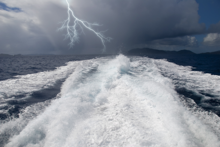

In [7]:
im = Image.open(dest)
im.to_thumb(220,220)

# * types

In [8]:
sea_types = 'stormy','calm'
path = Path('seas')

In [9]:
if not path.exists():
    path.mkdir()
    for i in sea_types:
        dest = (path/i)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{i} sea')
        download_images(dest, urls=results)

# * get paths

In [10]:
fns = get_image_files(path)
fns

(#381) [Path('seas/stormy/fd6a019b-f9ff-4dbd-a362-ea1246fa7572.jpg'),Path('seas/stormy/6e5b3bd9-7262-4153-8219-8665d9ced183.jpg'),Path('seas/stormy/5cf8fd15-f67f-4dfc-b2a6-661133910879.jpg'),Path('seas/stormy/0c8bed6f-b966-4dc4-954a-45ed3deb2a2a.jpg'),Path('seas/stormy/015d6cb2-1c4c-477b-8ad7-48b9b842c178.jpg'),Path('seas/stormy/7dd97db9-0627-4ad5-9882-3c089243d09b.jpg'),Path('seas/stormy/48220a9b-cc22-4db0-a661-6f5eecb38300.jpg'),Path('seas/stormy/c0ebdc36-6519-4ad5-aa7e-d4c4a61db280.jpg'),Path('seas/stormy/42327f33-f860-46f0-befe-79ca65451cac.jpg'),Path('seas/stormy/586a21f7-036b-4296-b784-e18141baeb91.jpg')...]

# * delete if failed

In [11]:
failed = verify_images(fns)
failed

(#6) [Path('seas/stormy/5cf8fd15-f67f-4dfc-b2a6-661133910879.jpg'),Path('seas/stormy/d0b1a77e-c9ba-4eb4-b437-1dd32e6c7528.jpg'),Path('seas/calm/6c5894d7-babd-474b-840f-2fda02a0186a.jpg'),Path('seas/calm/9e589caa-1610-41f6-9a2a-4e7c59ac8f44.jpg'),Path('seas/calm/0f5696bb-c826-468c-bb76-b902c7fdf161.jpg'),Path('seas/calm/5708f1b7-c9ec-4f4c-9264-95e566b7cd29.jpg')]

In [12]:
failed.map(Path.unlink)

(#6) [None,None,None,None,None,None]

# * get data 

In [13]:
seas = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [14]:
dls = seas.dataloaders(path)

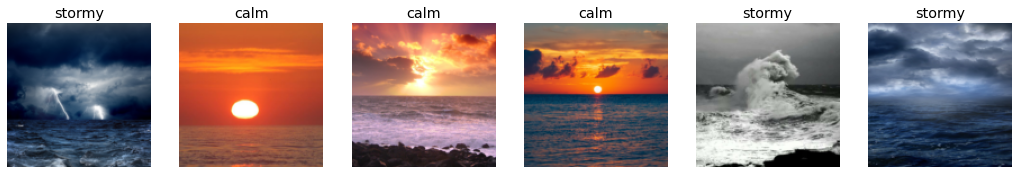

In [15]:
dls.valid.show_batch(max_n=6, nrows=1)

# just resize

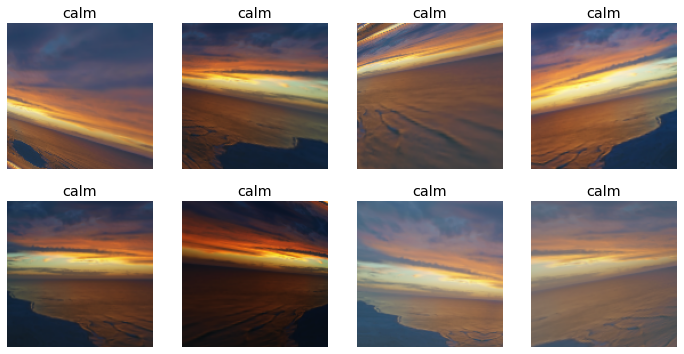

In [16]:
seas = seas.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = seas.dataloaders(path)
dls.train.show_batch(max_n=8, nrows = 2, unique = True)

# * train model

In [17]:
seas = seas.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = seas.dataloaders(path)

# * learner

In [18]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.014655,0.480680,0.226667,00:51


epoch,train_loss,valid_loss,error_rate,time
0,0.548453,0.293172,0.106667,01:04
1,0.449384,0.205580,0.080000,01:01
2,0.340557,0.178395,0.080000,01:00
3,0.301077,0.180668,0.093333,01:01


# * confusion matrix

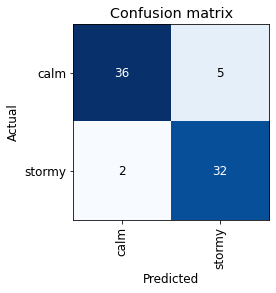

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# * prediction/actual/loss/probability(confidence)

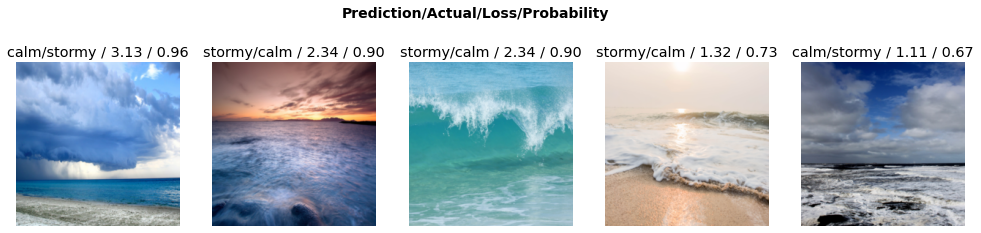

In [20]:
interp.plot_top_losses(5, nrows=1, figsize=(17,4))

# * clean wrongly labeled 

In [21]:
cleaner = ImageClassifierCleaner(learn)

# * delete wrongly labeled images and move to new folder 

In [22]:
for idx in cleaner.delete():cleaner.fns[idx].unlink()
for idx,cat in cleaner.change():shutil.move(str(cleaner.fns[idx]),path/cat)